# Implementation of Boundary Equilibrium GANs
Reference: https://arxiv.org/pdf/1703.10717

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
import glob

In [6]:
from PIL import Image

In [54]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [8]:
MODEL_NAME = 'BEGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
IMAGE_DIM = (64, 64, 3)

In [10]:
def tensor2img(tensor):
    img = (np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.
    return img

In [11]:
def get_sample_image(G, n_noise=100, n_samples=64):
    """
        save sample 100 images
    """
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(DEVICE) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return result

In [12]:
class Encoder(nn.Module):
    """
        Convolutional Encoder
    """
    def __init__(self, in_channel=1, n_filters=128, hidden_dim=100):
        super(Encoder, self).__init__()
        assert IMAGE_DIM[0] % 2**2 == 0, 'Should be divided 4'
        self.flatten_dim = IMAGE_DIM[0]//2**2
        self.conv = nn.Sequential(
            # conv0
            nn.Conv2d(in_channel, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv1
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv2
            nn.Conv2d(n_filters, n_filters*2, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            # conv3
            nn.Conv2d(n_filters*2, n_filters*2, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            # conv4
            nn.Conv2d(n_filters*2, n_filters*3, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
            # conv5
            nn.Conv2d(n_filters*3, n_filters*3, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters*3, n_filters*3, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
#             nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(self.flatten_dim**2*n_filters*3, hidden_dim)
    
    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

In [13]:
class Decoder(nn.Module):
    """
        Convolutional Decoder
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=100):
        super(Decoder, self).__init__()
        assert IMAGE_DIM[0] % 2**2 == 0, 'Should be divided 4'
        self.flatten_dim = IMAGE_DIM[0]//2**2
        self.fc = nn.Sequential(
            nn.Linear(n_noise, self.flatten_dim**2*n_filters),
        )
        self.conv = nn.Sequential(
            # conv1
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv2
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # conv3
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv4
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # conv5
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters, out_channel, 3, stride=1, padding=1, bias=True),
            nn.Tanh()
        )
    
    def forward(self, h):
        h = self.fc(h)
        h = h.view(h.size(0), -1, self.flatten_dim, self.flatten_dim)
        x = self.conv(h)
        return x

In [14]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator
    """
    def __init__(self, in_channel=1, n_filters=128, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.encoder = Encoder(in_channel=in_channel, n_filters=n_filters, hidden_dim=hidden_dim)
        self.decoder = Decoder(out_channel=in_channel, n_filters=n_filters, n_noise=hidden_dim)
        
    def forward(self, x):
        h = self.encoder(x)
        x_ = self.decoder(h)
        return x_

In [15]:
class Generator(nn.Module):
    """
        Convolutional Generator
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=64):
        super(Generator, self).__init__()
        self.decoder = Decoder(out_channel=out_channel, n_filters=n_filters, n_noise=n_noise)
        
    def forward(self, h):
        x_ = self.decoder(h)
        return x_

In [16]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

CelebA-aligned download: [link](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

In [17]:
dataset = datasets.ImageFolder(root='/home/yangyangii/gans/CelebA/dataset', transform=transform)

In [18]:
batch_size = 32
n_noise = 64

In [19]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8, pin_memory=True)

In [20]:
D = Discriminator(in_channel=IMAGE_DIM[-1], hidden_dim=n_noise).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1], n_noise=n_noise).to(DEVICE)

In [21]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [22]:
# BEGAN causes mode collapse. it can be addressed by decaying lr
D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3, 10, 17], gamma=0.6)
G_scheduler = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3, 10, 17], gamma=0.6)

In [23]:
criterion = nn.L1Loss()

In [24]:
max_epoch = 20
step = 0

In [25]:
lr_k = 0.001
gamma = 0.7
k_t = 0
log_term = 1000

In [26]:
steps_per_epoch = len(data_loader.dataset) // batch_size
steps_per_epoch

6331

In [27]:
if not os.path.exists('samples'):
    os.makedirs('samples')
    
if not os.path.exists('ckpt'):
    os.makedirs('ckpt')

In [28]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [29]:
m_lst = []
bestM = 1.
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        G.zero_grad()
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, x)

        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake.detach())
        D_z_loss = criterion(z_outputs, x_fake)
        
        D_loss = D_x_loss - k_t*D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake)
        G_loss = criterion(x_fake, z_outputs)

        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        bal = (gamma*D_x_loss - G_loss).detach()
        k_t = min(max(k_t + lr_k*bal, 0), 1)
        M_global = D_x_loss.detach() + torch.abs(bal)
        
        if M_global.item() < bestM:
            bestM = M_global.item()
            save_checkpoint({'global_step': step,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                'ckpt/began{:06d}.pth.tar'.format(step))
        
        if step % log_term == 0:
            m_lst.append(M_global)
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, k: {:.4f}, M: {:.4f}, lr: {:.7f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), k_t, M_global.item(), G_scheduler.get_lr()[0], dt))
            G.eval()
            img = get_sample_image(G, n_noise, n_samples=25)
            imsave('samples/{}_step{:06d}.jpg'.format(MODEL_NAME, step), img)
            G.train()
        
        step += 1
    D_scheduler.step()
    G_scheduler.step()

/home/yangyangii/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Epoch: 0/20, Step: 0, D Loss: 0.5115, G Loss: 0.2565, k: 0.0001, M: 0.6131, lr: 0.0002000, Time:20:18:28
Epoch: 0/20, Step: 1000, D Loss: 0.1368, G Loss: 0.0665, k: 0.0341, M: 0.1698, lr: 0.0002000, Time:20:25:16
Epoch: 0/20, Step: 2000, D Loss: 0.1480, G Loss: 0.0705, k: 0.0655, M: 0.1882, lr: 0.0002000, Time:20:32:00
Epoch: 0/20, Step: 3000, D Loss: 0.1428, G Loss: 0.0965, k: 0.0797, M: 0.1571, lr: 0.0002000, Time:20:38:42
Epoch: 0/20, Step: 4000, D Loss: 0.1348, G Loss: 0.0875, k: 0.0853, M: 0.1536, lr: 0.0002000, Time:20:45:25
Epoch: 0/20, Step: 5000, D Loss: 0.1275, G Loss: 0.0940, k: 0.0894, M: 0.1356, lr: 0.0002000, Time:20:52:07
Epoch: 0/20, Step: 6000, D Loss: 0.1070, G Loss: 0.0790, k: 0.0908, M: 0.1158, lr: 0.0002000, Time:20:58:50
Epoch: 1/20, Step: 7000, D Loss: 0.1168, G Loss: 0.0831, k: 0.0905, M: 0.1292, lr: 0.0002000, Time:21:05:33
Epoch: 1/20, Step: 8000, D Loss: 0.1191, G Loss: 0.0991, k: 0.0883, M: 0.1375, lr: 0.0002000, Time:21:12:16
Epoch: 1/20, Step: 9000, D Loss

Epoch: 12/20, Step: 76000, D Loss: 0.1038, G Loss: 0.0722, k: 0.0391, M: 0.1091, lr: 0.0000720, Time:04:54:32
Epoch: 12/20, Step: 77000, D Loss: 0.1000, G Loss: 0.0767, k: 0.0383, M: 0.1076, lr: 0.0000720, Time:05:01:21
Epoch: 12/20, Step: 78000, D Loss: 0.0993, G Loss: 0.0734, k: 0.0376, M: 0.1040, lr: 0.0000720, Time:05:08:10
Epoch: 12/20, Step: 79000, D Loss: 0.0974, G Loss: 0.0718, k: 0.0374, M: 0.1019, lr: 0.0000720, Time:05:14:58
Epoch: 12/20, Step: 80000, D Loss: 0.0999, G Loss: 0.0703, k: 0.0373, M: 0.1042, lr: 0.0000720, Time:05:21:47
Epoch: 12/20, Step: 81000, D Loss: 0.0949, G Loss: 0.0721, k: 0.0373, M: 0.1014, lr: 0.0000720, Time:05:28:36
Epoch: 12/20, Step: 82000, D Loss: 0.1020, G Loss: 0.0761, k: 0.0367, M: 0.1075, lr: 0.0000720, Time:05:35:25
Epoch: 13/20, Step: 83000, D Loss: 0.1046, G Loss: 0.0730, k: 0.0363, M: 0.1093, lr: 0.0000720, Time:05:42:14
Epoch: 13/20, Step: 84000, D Loss: 0.0937, G Loss: 0.0726, k: 0.0360, M: 0.1015, lr: 0.0000720, Time:05:49:03
Epoch: 13/

In [33]:
save_checkpoint({'global_step': step,
     'D':D.state_dict(),
     'G':G.state_dict(),
     'd_optim': D_opt.state_dict(),
     'g_optim' : G_opt.state_dict()},
    'ckpt/began{:06d}.pth.tar'.format(step))

### Random Sample

In [38]:
G_path = sorted(glob.glob(os.path.join('ckpt', '*.pth.tar')))[-2]
state = torch.load(G_path)
G.load_state_dict(state['G'])

In [39]:
G.eval()
None

/home/yangyangii/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


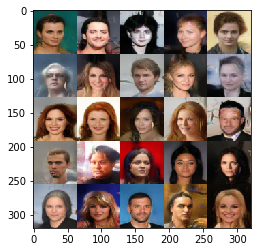

In [41]:
img = get_sample_image(G, n_noise, n_samples=25)
imshow(img)

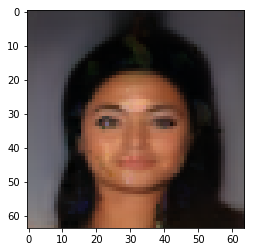

In [47]:
# Fake Image
idx = [3, 3]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
imshow(img[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

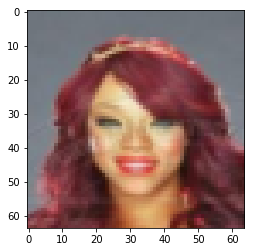

In [48]:
# Real Image
i = 14
rimg = tensor2img(images[i])
imshow(rimg)

### Interpolation

In [49]:
def sample_noise(size=None):
    z = np.random.random(size=size)*2-1
    return z

In [50]:
z_a, z_b = sample_noise(n_noise), sample_noise(n_noise)
zs = torch.tensor([np.linspace(z_a[i], z_b[i], num=10) for i in range(n_noise)], dtype=torch.float32).to(DEVICE)
zs = torch.transpose(zs, 0, 1)
zs.shape

torch.Size([10, 64])

In [51]:
imgs = G(zs).detach()
imgs = torch.cat([imgs[i] for i in range(10)], dim=-1)
imgs.shape

/home/yangyangii/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


torch.Size([3, 64, 640])

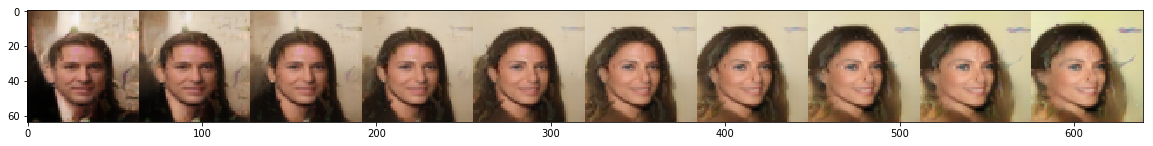

In [56]:
fig = plt.figure(figsize=(20, 3))
imshow(tensor2img(imgs))